# Overview of the ``mdof`` package

<div>
<img src="./figures/mdof_overview.png" width="200"/>
</div>

The `mdof` package is designed to provide a convenient interface for computing dynamic analyses of structural vibrations.

## Installation

If you'd like to install `mdof` in your own environment to work with it locally, install mdof from [pypi](https://pypi.org/project/mdof/).  In your environment manager (e.g., Anaconda),

```bash
    pip install mdof
```

Install the required packages.

In [1]:
# !pip install -Ur requirements.txt

## Import

In Python, import the package.

In [2]:
import mdof

## Investigate Structural Vibrations

Load an the input motion, output motion, and time vector for a mystery structural system.

<div><center>
<img src="./figures/mystery_system.png" width="550"/>
</center></div>

In [3]:
import numpy as np
input_motion = np.loadtxt("uploads/input_motion.txt")
output_motion = np.loadtxt("uploads/output_motion.txt")
times = np.loadtxt("uploads/times.txt")

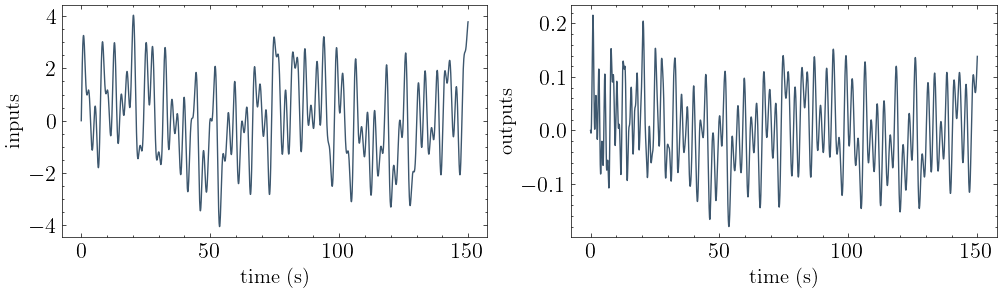

In [4]:
from mdof.utilities.printing import plot_io
plot_io(input_motion, output_motion, times)

### Inverse Eigenanalysis with `mdof.eigid()`

<div><center>
<img src="./figures/eigid.png" width="550"/>
</center></div>

In [5]:
eigvals, eigvecs = mdof.eigid(input_motion, output_motion, order=2)

100%|█████████▉| 4700/4701 [00:00<00:00, 86936.63it/s]


In [6]:
print(f"{eigvals=}\n {eigvecs=}")

eigvals=array([0.98491199+0.16330168j, 0.98491199-0.16330168j])
 eigvecs=array([[ 0.71332805+0.j        ,  0.71332805-0.j        ],
       [-0.00497201+0.70081265j, -0.00497201-0.70081265j]])


### State Space Realization with `mdof.sysid()`

<div><center>
<img src="./figures/sysid.png" width="550"/>
</center></div>

In [7]:
A,B,C,D = mdof.sysid(input_motion, output_motion, order=2)

100%|█████████▉| 4700/4701 [00:00<00:00, 90175.74it/s]


In [8]:
print(f"{A=} \n{B=} \n{C=} \n{D=}")

A=array([[ 0.98607055,  0.16621799],
       [-0.16044462,  0.98375342]]) 
B=array([[-0.1743355 ],
       [-0.10978558]]) 
C=array([[-0.05126065,  0.08870003]]) 
D=array([[-0.09489982]])


### Modal Estimation with `mdof.modes()`

<div><center>
<img src="./figures/modal.png" width="550"/>
</center></div>

In [9]:
modes = mdof.modal.system_modes(mdof.system(input_motion, output_motion, order=2), dt=times[1]-times[0])

100%|█████████▉| 4700/4701 [00:00<00:00, 96502.44it/s]


In [10]:
from mdof.utilities.printing import print_modes
print_modes(modes)

Spectral quantities:
       T(s)        ζ        EMACO      MPC       EMACO*MPC
      1.147      0.01       1.0        1.0        1.0      
Mean Period(s): 1.1471474419090961
Standard Dev(s): 0.0


### Spectra with `power_transfer()` and `spectrum_modes()`

In [11]:
from mdof.transform import power_transfer
periods, amplitudes = power_transfer(input_motion, output_motion, step=times[1]-times[0], period_band=(0,5))

In [12]:
from mdof.modal import spectrum_modes
peak_period, peak_amplitude = spectrum_modes(periods, amplitudes)
print(f"{peak_period=}")

peak_period=array([1.14503817])


In [13]:
from mdof.utilities.printing import plot_transfer
plot_transfer(np.array([periods,amplitudes]), plotly=True)

### Stablization Diagram with `stabilization()`

In [14]:
from mdof.macro import stabilization
fig = stabilization(input_motion, output_motion, dt=times[1]-times[0], orders=(2,50,2), plotly=True)

100%|█████████▉| 4700/4701 [00:04<00:00, 1108.41it/s]
/mnt/c/Users/16507/Documents/GitHub/mdof/src/mdof/validation.py:23: RuntimeWarning:

divide by zero encountered in scalar divide

100%|█████████▉| 4700/4701 [00:07<00:00, 655.02it/s]
